## Исследование поведения пользователей мобильного приложения

### План выполнения проекта

<br>1.[Открытие файла, изучение структуры данных](#step1)
<br>2.[Отчистка и подготовка данных к работе](#step2)
<br>3.[Изучение и проверка данных](#step3)
<br>4.[Изучение воронки событий](#step4)
<br>5.[Анализ результатов эксперемента](#step5)
<br>[ВЫВОДЫ](#step6)

### Шаг 1. Откроем файл с данными и изучим информацию<a id='step1'></a>

Здесь, помимо загрузки данных, будем импортировать все необходимые библиотеки

In [1]:
import pandas as pd
import datetime
import warnings
from scipy import stats as st
import numpy as np
import math as mth

warnings.filterwarnings('ignore')
data=pd.read_csv('/datasets/logs_exp.csv', sep='\t')
display(data)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


Данные требуют предварительной обработки

### Шаг 2. Подготовим данные<a id='step2'></a>

In [2]:
data.columns = ['event_name', 'user_id', 'event_time', 'group']
data['event_time'] = pd.to_datetime(data['event_time'], unit='s')
data['date'] = data['event_time'].dt.date
display(data.head())
#data.info()

,event_name,user_id,event_time,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


Пропусков в данных не обнаружено, тип данных в столбцах изменен на необходимый, добавлен столбец с датой.




### Шаг 3. Изучим и проверим данные<a id='step3'></a>

#### Проверим, сколько всего событий в логе.

In [3]:
print('Всего событий:', len(data))

Всего событий: 244126


#### Каково число пользователей?

In [4]:
print('Всего пользователей:', data['user_id'].nunique())

Всего пользователей: 7551


#### Сколько в среднем событий приходится на пользователя?

In [5]:
print('Событий на пользователя: {:.2f}'.format((len(data)/data['user_id'].nunique())))

Событий на пользователя: 32.33


#### Проверим, данными за какой период мы располагаем. 

In [6]:
print('Минимальная дата в данных:',data['date'].min())
print('Максимальная дата в данных:',data['date'].max())

Минимальная дата в данных: 2019-07-25
Максимальная дата в данных: 2019-08-07


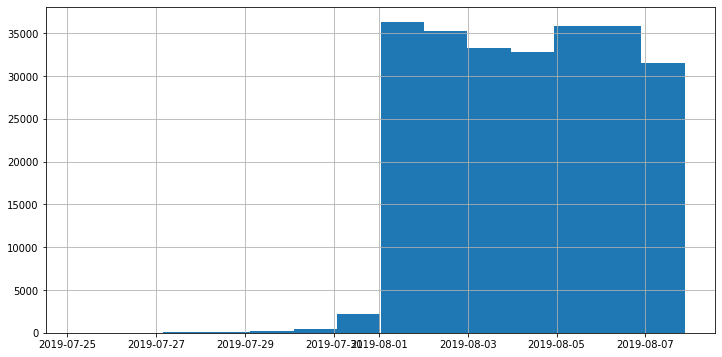

In [7]:
data['event_time'].hist(figsize=(12,6), bins=14);

Похоже на то, что полные данные появляются только с 1 августа. Таким образом бы располагаем реальными данными за неделю наблюдений: с 1ого по 7ое августа, остальные данные лучше отбросить.

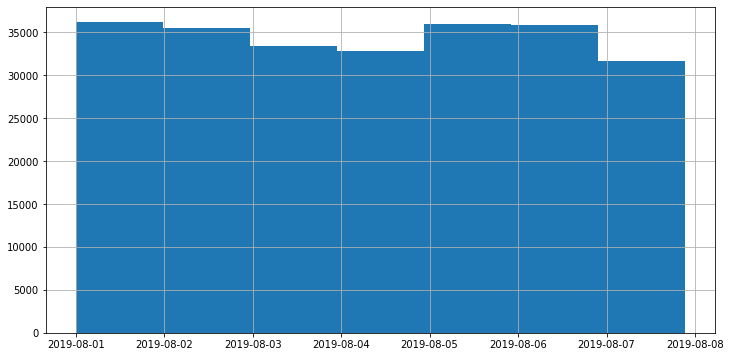

In [8]:
first_day = pd.to_datetime("2019-08-01").date()
data_new = data[data['date']>= first_day]

data_new['event_time'].hist(figsize=(12,6),bins=7);

Теперь данные выглядят равномерно. Реальное время эксперемента - 7 дней.


#### Проверим, много ли событий и пользователей мы потеряли, отрезав старые данные

In [9]:
print('Процент потерянных событий: {:.2%}'.format((len(data) - len(data_new)) / len(data)))
print('Процент потерянных пользователей: {:.2%}'.format((data['user_id'].nunique()-data_new['user_id'].nunique())/data['user_id'].nunique()))

Процент потерянных событий: 1.16%
Процент потерянных пользователей: 0.23%


#### Посмотрим, сколько пользователей у нас в разных группах?

In [10]:
data_new['group'].value_counts()

248    84726
246    79425
247    77147
Name: group, dtype: int64

Количество пользователей в группах не равно, но сопоставимо, с этими данными можно работать.

### Шаг 4. Изучим воронку событий<a id='step4'></a>

#### Посмотрим, какие события есть в логах, и как часто они встречаются

In [11]:
data_new['event_name'].value_counts()

MainScreenAppear           117431
OffersScreenAppear          46350
CartScreenAppear            42365
PaymentScreenSuccessful     34113
Tutorial                     1039
Name: event_name, dtype: int64

#### Подсчитаем, сколько пользователей совершали каждое событие

In [12]:
event_data = pd.DataFrame(data_new.groupby('event_name').agg({'user_id': 'nunique'}))
event_data = event_data.rename(columns={'user_id': 'users'})
event_data['users_percent'] = ((event_data['users'] / data_new['user_id'].nunique()) * 100).round(2)
display(event_data.sort_values('users', ascending=False))

,users,users_percent
event_name,,
MainScreenAppear,7419,98.47
OffersScreenAppear,4593,60.96
CartScreenAppear,3734,49.56
PaymentScreenSuccessful,3539,46.97
Tutorial,840,11.15


#### Предположим, в каком порядке происходят события, и выясним, все ли они выстраиваются в последовательную цепочку

События происходят впорядке уменьшения количества пользователей, дошедших до события: 'MainScreenAppear' ---> 'OffersScreenAppear' ---> 'CartScreenAppear' ---> 'PaymentScreenSuccessful'.
За исключением последней строки таблицы 'Tutorial' - cюда заходит лишь часть пользователей, которые не разобрались как пользоваться интерфейсом. И к воронке продаж, эта графа никак не относится. 

#### Подсчитаем какая доля пользователей проходит на следующий шаг воронки.

In [13]:
event_data = event_data.query('index != "Tutorial"')
event_data = event_data.sort_values('users', ascending=False)
event_data['funnel_percent'] = (event_data['users'].pct_change()+1)
event_data['funnel_percent'][0] = 1

display(event_data)

,users,users_percent,funnel_percent
event_name,,,
MainScreenAppear,7419,98.47,1.000000
OffersScreenAppear,4593,60.96,0.619086
CartScreenAppear,3734,49.56,0.812976
PaymentScreenSuccessful,3539,46.97,0.947777


Больше всего пользователей, а именно 38%, теряется на первом шаге,при переходе с главного экрана на экркан комерческого предложения.

#### Посмотрим какая доля пользователей доходит от первого события до оплаты:

In [14]:
general_funnel_percent = (event_data['users'][3] / event_data['users'][0])
print('Доля пользователей, дошедшая до оплаты: {:.1%}'.format(general_funnel_percent))

Доля пользователей, дошедшая до оплаты: 47.7%


### Шаг 5. Изучим результаты эксперимента<a id='step5'></a>

#### Проверим еще раз число пользователей вразных эксперементальных группах

In [15]:
display(data_new['group'].value_counts())



248    84726
246    79425
247    77147
Name: group, dtype: int64

####  Проверим, находят ли статистические критерии разницу между выборками А/А эксперемента 246 и 247.

Разделим данные на 3 группы:

In [16]:
group_246 = data_new.query('group == "246"')
group_247 = data_new.query('group == "247"')
group_248 = data_new.query('group == "248"')
group_A = data_new.query('group < 248')

#построим воронки для всех 3-х тестовых групп и объедененной группы А:
group_246_funnel = pd.DataFrame(group_246.groupby('event_name').agg({'user_id': 'nunique'}).sort_values('user_id', ascending=False))
group_246_funnel = group_246_funnel.rename(columns={'user_id': 'users'})
group_246_funnel = group_246_funnel.query('index != "Tutorial"')
group_246_funnel['full_group'] = group_246['user_id'].nunique()
display(group_246_funnel)

group_247_funnel = pd.DataFrame(group_247.groupby('event_name').agg({'user_id': 'nunique'}).sort_values('user_id', ascending=False))
group_247_funnel = group_247_funnel.rename(columns={'user_id': 'users'})
group_247_funnel = group_247_funnel.query('index != "Tutorial"')
group_247_funnel['full_group'] = group_247['user_id'].nunique()
display(group_247_funnel)

group_248_funnel = pd.DataFrame(group_248.groupby('event_name').agg({'user_id': 'nunique'}).sort_values('user_id', ascending=False))
group_248_funnel = group_248_funnel.rename(columns={'user_id': 'users'})
group_248_funnel = group_248_funnel.query('index != "Tutorial"')
group_248_funnel['full_group'] = group_248['user_id'].nunique()
display(group_248_funnel)

group_A_funnel = pd.DataFrame(group_A.groupby('event_name').agg({'user_id': 'nunique'}).sort_values('user_id', ascending=False))
group_A_funnel = group_A_funnel.rename(columns={'user_id': 'users'})
group_A_funnel = group_A_funnel.query('index != "Tutorial"')
group_A_funnel['full_group'] = group_A['user_id'].nunique()
display(group_A_funnel)

,users,full_group
event_name,,
MainScreenAppear,2450,2484
OffersScreenAppear,1542,2484
CartScreenAppear,1266,2484
PaymentScreenSuccessful,1200,2484


,users,full_group
event_name,,
MainScreenAppear,2476,2513
OffersScreenAppear,1520,2513
CartScreenAppear,1238,2513
PaymentScreenSuccessful,1158,2513


,users,full_group
event_name,,
MainScreenAppear,2493,2537
OffersScreenAppear,1531,2537
CartScreenAppear,1230,2537
PaymentScreenSuccessful,1181,2537


,users,full_group
event_name,,
MainScreenAppear,4926,4997
OffersScreenAppear,3062,4997
CartScreenAppear,2504,4997
PaymentScreenSuccessful,2358,4997


###### Сравним все шаги воронки двух тестовых групп:
<br> Выдвеним нулевую гипотезу о равенстве долей пользователей на каждом шаге групп 246 и 247:

In [17]:
# напишем функцию, для проведения z-теста любого шага воронки 2-х тестовых групп:
def z_test(groupA, groupB, step):
    alpha = .05/3 # критический уровень статистической значимости

    successes = np.array([groupA['users'][step], groupB['users'][step]])
    trials = np.array([groupA['users'][step-1], groupB['users'][step-1]])

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными") 

#Сравним все шаги воронки двух тестовых групп:
z_test(group_246_funnel, group_247_funnel, 1)
z_test(group_246_funnel, group_247_funnel, 2)
z_test(group_246_funnel, group_247_funnel, 3)

p-значение:  0.2622344959255778
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.6393754713145263
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.18243439408067652
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Ни на одном из шагов не получилось отвергнуть нулевую гипотезу, значит разделение групп выполнено корректно.

#### Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп.

Самое популярное событие "MainScreenAppear" - открытие стартовой страницы. Подсчитаем долю пользователей группы, открывших стартовую страницу.	

In [18]:
#display(group_246.head())
MainScreenAppear_246 = group_246_funnel['users'][0] / group_246['user_id'].nunique()
print('Доля пользователей группы 246, открывших стартовую страницу: {:.2%}'.format(MainScreenAppear_246))

MainScreenAppear_247 = group_247_funnel['users'][0] / group_247['user_id'].nunique()
print('Доля пользователей группы 247, открывших стартовую страницу: {:.2%}'.format(MainScreenAppear_247))

MainScreenAppear_248 = group_248_funnel['users'][0] / group_248['user_id'].nunique()
print('Доля пользователей группы 248, открывших стартовую страницу: {:.2%}'.format(MainScreenAppear_248))

Доля пользователей группы 246, открывших стартовую страницу: 98.63%
Доля пользователей группы 247, открывших стартовую страницу: 98.53%
Доля пользователей группы 248, открывших стартовую страницу: 98.27%


Напишем функцию для проведения z-теста, для проверки гипотизы о равенстве конверсий воронок разных тестовых групп

In [19]:
def z_test2(group1, group2, event_place):
    alpha = .05/16 # критический уровень статистической значимости

    successes = np.array([group1['users'][event_place], group2['users'][event_place]])
    trials = np.array([group1['full_group'][event_place], group2['full_group'][event_place]])

# пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
    difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

       

Проверем, будет ли отличие между контрольными группами статистически достоверным по всем 4 событиям.<br> Нулевая гипотеза: контрольные группы 246 и 247 взяты из одной генеральной совокупности.

In [20]:
z_test2(group_246_funnel, group_247_funnel, 0) 
z_test2(group_246_funnel, group_247_funnel, 1)
z_test2(group_246_funnel, group_247_funnel, 2)
z_test2(group_246_funnel, group_247_funnel, 3)

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Не удалось отвергнуть нулевую гипотезу, с большой вероятностью обе контрольные группы принадлежат к одной генеральной совокупности. Разбиение на группы работает корректно.

#### Сравним группу с измененным шрифтом(248) с каждой из контрольных групп:

In [21]:
z_test2(group_246_funnel, group_248_funnel, 0) 
z_test2(group_246_funnel, group_248_funnel, 1)
z_test2(group_246_funnel, group_248_funnel, 2)
z_test2(group_246_funnel, group_248_funnel, 3)

z_test2(group_247_funnel, group_248_funnel, 0) 
z_test2(group_247_funnel, group_248_funnel, 1)
z_test2(group_247_funnel, group_248_funnel, 2)
z_test2(group_247_funnel, group_248_funnel, 3)

p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


В результате тестов, не удалось ни разу отвергнуть нулевую гипотезу о равенстве групп. <br>Попробуем сравнить группу 248 с объедененной группой А.

In [22]:
z_test2(group_A_funnel, group_248_funnel, 0) 
z_test2(group_A_funnel, group_248_funnel, 1)
z_test2(group_A_funnel, group_248_funnel, 2)
z_test2(group_A_funnel, group_248_funnel, 3)

p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Предсказуемо, результаты теста не изменились, по-прежнему не удалось отвергнуть нулевую гипотезу. Таким образом в результате А/В теста не удалось выявить статистически значимых различий в конверсии в контрольной группе и группе 248.

#### Подсчитаем, сколько проверок статистических гипотез мы выполнили.

Всего за проект мы проверили 19 гипотез, но 3 из них проверялись в первом случае и 16 во втором. Используем эти значения, для корректировки alpha поправкой Бонферрони(добавленна выше в код).

### Выводы<a id='step6'></a>

Исследование показало, что разбивка на группы для проведения А/В теста была выполнена корректно. Анализ самого А/В теста показал, что статистически значимых различий в конверсии групп А и В обнаружено не было. Таким образом, с большой долей вероятности можно утверждать, что изменение шрифта в приложении статистически значимо не отразилось на конверсии пользователей.